In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn import metrics

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data/training_set_VU_DM_2014.csv")

# Data Cleaning

In [3]:
dates = data["date_time"]
dates = pd.to_datetime(dates)
days = np.empty(len(dates), np.int32)
months = np.empty(len(dates), np.int32)
times = np.empty(len(dates), np.int32)

for i, date in enumerate(dates):
    days[i] = date.isoweekday()
    months[i] = date.month
    times[i] = date.hour

In [4]:
position = data['position']

price = data['price_usd']
price_stars = data['price_usd'] / (data['prop_starrating'] + 1)

review_score = np.array(data['prop_review_score'], np.float32)
review_score[np.isnan(review_score)] = np.percentile(review_score[~np.isnan(review_score)], 25)

location_score_2 = np.array(data['prop_location_score2'], np.float32)
location_score_2[np.isnan(location_score_2)] = min(location_score_2[~np.isnan(location_score_2)])

star_rating = data['prop_starrating']


In [7]:
features = np.array([
    price,
    price_stars,
    review_score,
    location_score_2,
    star_rating,
    days,
    months,
    times
], np.float32).T
labels = np.array(data['click_bool'], np.bool)

# Validation

             precision    recall  f1-score   support

      False       0.97      0.56      0.71      9536
       True       0.07      0.65      0.12       464

avg / total       0.93      0.56      0.68     10000



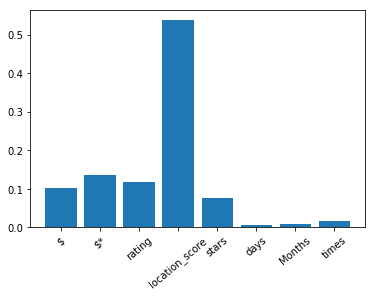

In [9]:
positive_N = 5000
negative_N = 5000

positive_indices = np.argwhere(labels).ravel()
negative_indices = np.argwhere(~labels).ravel()


train_samples = np.concatenate([
    np.random.choice(positive_indices, positive_N),
    np.random.choice(negative_indices, negative_N),
])

test_samples = np.random.choice(len(data), positive_N + negative_N)
# test_samples = np.concatenate([
#     np.random.choice(positive_indices, positive_N),
#     np.random.choice(negative_indices, negative_N),
# ])

train_features = features[train_samples]
train_labels = labels[train_samples]

test_features = features[test_samples]
test_labels = labels[test_samples]

classifier = RandomForestClassifier(200, max_depth=3, class_weight="balanced")
classifier.fit(train_features, train_labels)
predict_labels = classifier.predict(test_features)
print(metrics.classification_report(test_labels, predict_labels))

# scores = cross_val_score(classifier, train_features, train_labels, cv=3)
# print("Decision Tree : Accuracy: {:3.5f} (+/- {:3.4e})".format(scores.mean(), scores.std() * 2))

n = range(len(classifier.feature_importances_))
plt.bar(n, classifier.feature_importances_)
plt.xticks(n, ["$", "$*", "rating", "location_score", "stars", "days", "Months", "times"], rotation=40)
plt.show()